In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
# Lecture Tables
# Load patients data
patients = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')

# Load admissions data
admissions = pd.read_csv('mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')

# Load diagnoses_icd data
diagnoses = pd.read_csv('mimic-iii-clinical-database-demo-1.4/DIAGNOSES_ICD.csv')

# Load D_ICD_DIAGNOSES data
diagnoses_labels = pd.read_csv('mimic-iii-clinical-database-demo-1.4/D_ICD_DIAGNOSES.csv')

# Load ICUSTAYS data
icustays = pd.read_csv('mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv')

In [43]:
# Custom Tables
prescriptions = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv')

ICU Stay Outcomes
Story: What factors impact patient mortality during ICU stays?

Determine which types of ICU stays have higher mortality rates.
Understand if longer stays correlate with better or worse outcomes.

In [44]:
# Merge necessary columns for analysis

# Adding mortality flag from admissions_df to icustays_df
icu_admissions = icustays.merge(admissions[['hadm_id', 'hospital_expire_flag']], on='hadm_id', how='left')

# Adding stay_type for grouped analysis
icu_admissions['stay_type'] = icu_admissions['first_careunit']

# Calculate medication count by patient

# This requires joining prescriptions with icustays to match ICU admissions
prescriptions_count = prescriptions.groupby('hadm_id').size().reset_index(name='medication_count')
icu_admissions = icu_admissions.merge(prescriptions_count, on='hadm_id', how='left')

# Fill NaN values in medication_count with 0
icu_admissions['medication_count'] = icu_admissions['medication_count'].fillna(0)

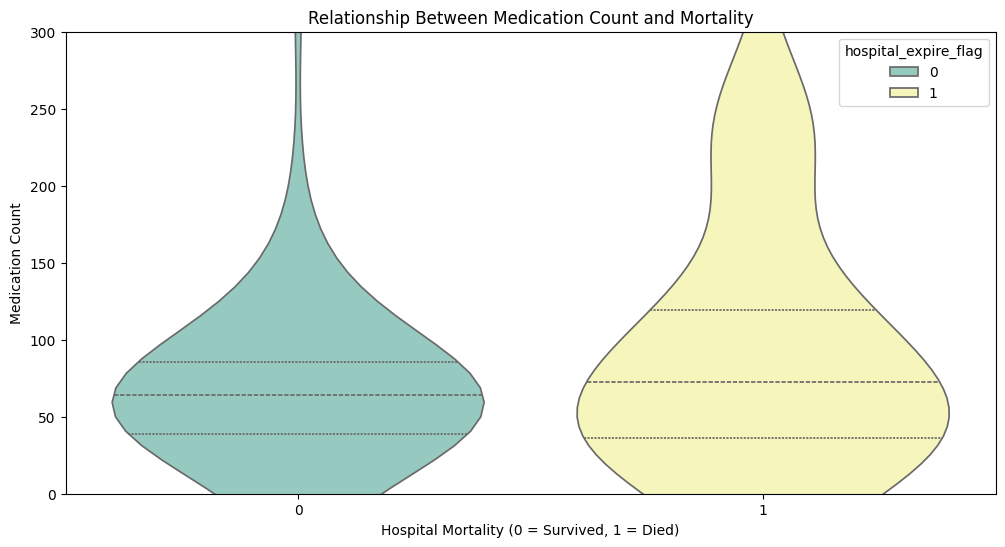

In [45]:
# Create a violin plot to show the distribution of medication count by mortality
plt.figure(figsize=(12, 6))
sns.violinplot(data=icu_admissions, x='hospital_expire_flag', y='medication_count', palette="Set3", hue = 'hospital_expire_flag',inner="quartile")
plt.title('Relationship Between Medication Count and Mortality')
plt.xlabel('Hospital Mortality (0 = Survived, 1 = Died)')
plt.ylabel('Medication Count')
plt.ylim(0, 300)  # Ignore outliers, over 300 medications is too much
plt.show()

From this data we can see that more people passed away who take higher amounts of medication as compared to people who survived

<Axes: xlabel='los', ylabel='Count'>

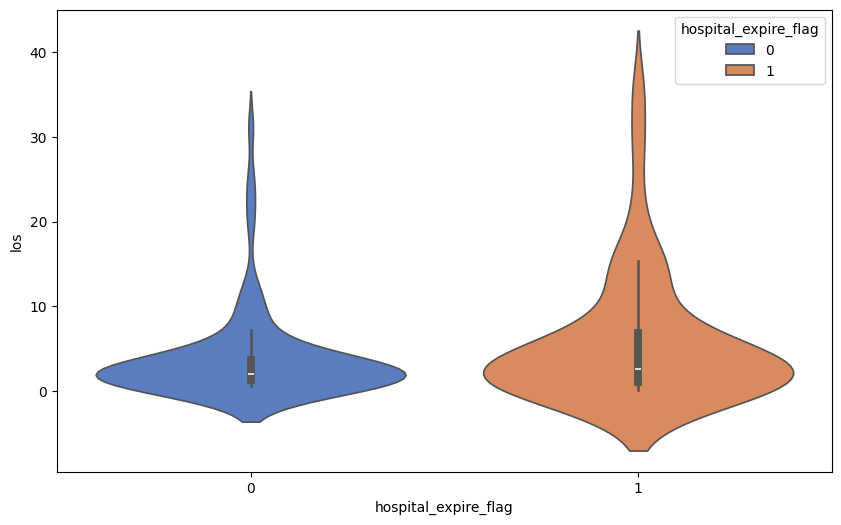

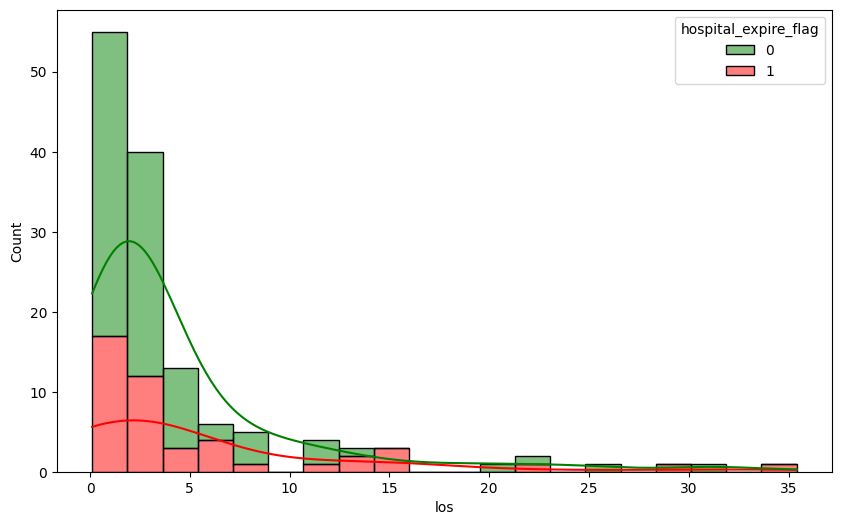

In [46]:
# Violin Plot: Length of stay distribution for survivors vs. deceased patients
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="hospital_expire_flag", y="los", data=icu_admissions, palette="muted", hue="hospital_expire_flag", density_norm="width"
)

# Plot ICU stay length distribution by mortality
plt.figure(figsize=(10, 6))
sns.histplot(
    data=icu_admissions,
    x="los",
    hue="hospital_expire_flag",
    bins=20,
    kde=True,
    palette={0: "green", 1: "red"},
    multiple="stack",
)

From the above charts we can see that majority of the patients stay in the ICU for less than 10 days.
We can also see that how long someone stays in the ICU probably does not have an effect on if they die or not. Day 15 has no survivors but day 20 has no deaths. then after that we can see a mix of the two. This means that ICU stay duration does not have an effect on the survival of the patients

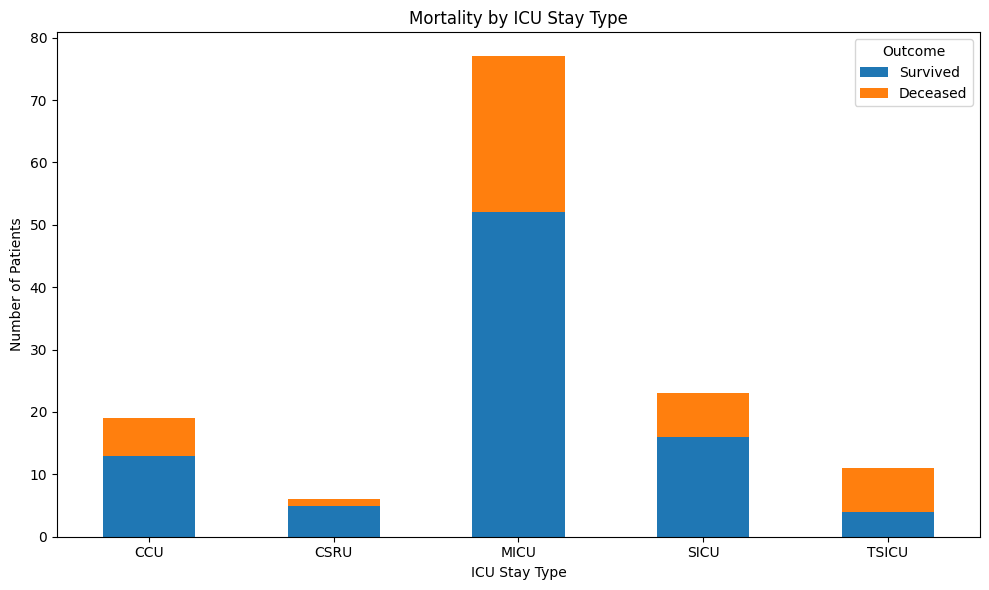

In [47]:
# Stacked Bar Chart: ICU stay type vs. mortality
mortality_staytype = icu_admissions.groupby(["stay_type", "hospital_expire_flag"]).size().unstack(fill_value=0)
mortality_staytype.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Mortality by ICU Stay Type")
plt.xlabel("ICU Stay Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.legend(["Survived", "Deceased"], title="Outcome")
plt.tight_layout()
plt.show()

From the above chart we can see that TSICU has the highest mortality rate

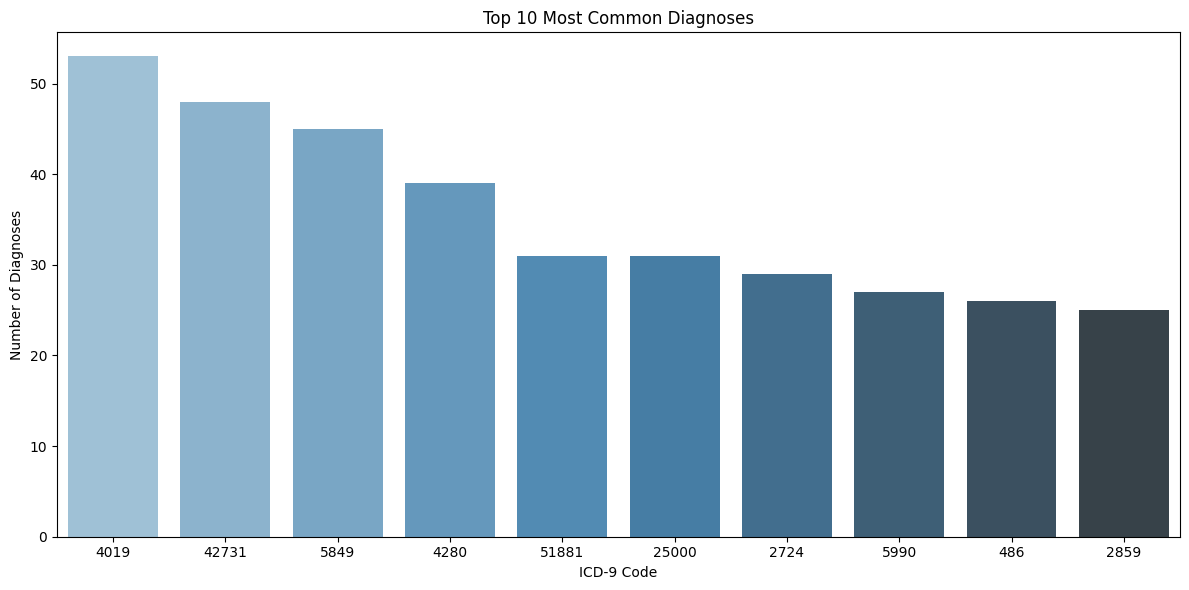

In [48]:
# Figure 4: Most common diagnoses
most_common_diagnoses = diagnoses['icd9_code'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=most_common_diagnoses.index, y=most_common_diagnoses.values, palette="Blues_d", hue=most_common_diagnoses.index)
plt.title("Top 10 Most Common Diagnoses")
plt.xlabel("ICD-9 Code")
plt.ylabel("Number of Diagnoses")
plt.tight_layout()

Here we can see the ICD9 codes for the diagnoses but its better to have in a more human readable format

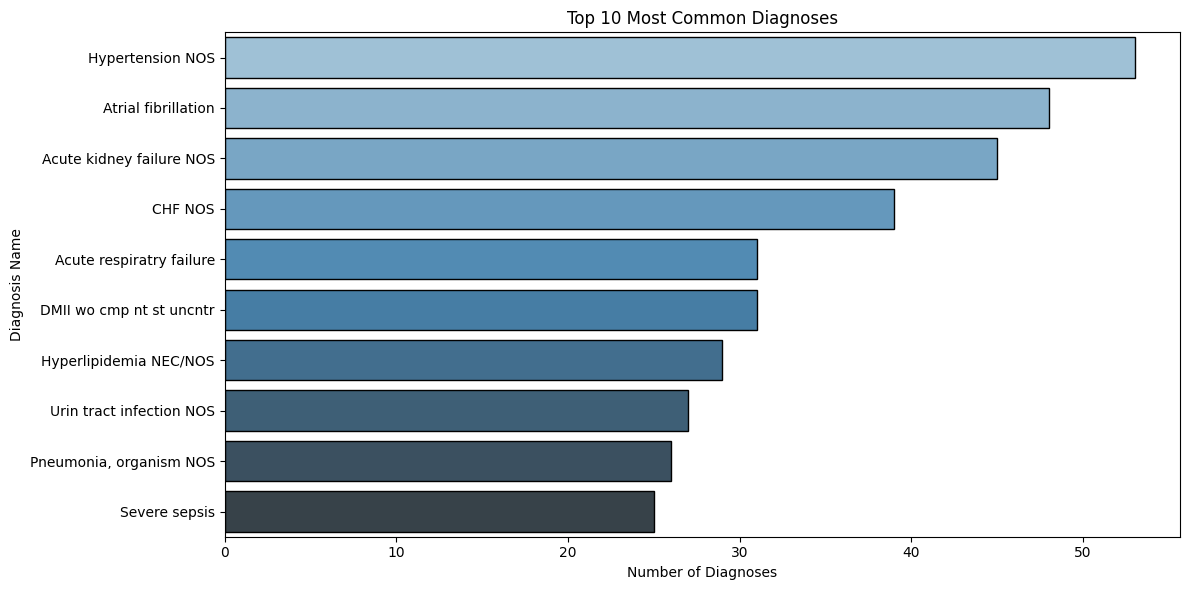

In [49]:
# Merge the DIAGNOSES_ICD dataset with the D_ICD_DIAGNOSES to get names of the diagnoses
diagnoses_with_names = diagnoses.merge(
    diagnoses_labels, 
    how='left', 
    on='icd9_code'
)

# Merge diagnoses with admissions to include mortality information
diagnoses_with_admissions = diagnoses_with_names.merge(admissions, how='left', on='hadm_id')

# Get the top 10 most common diagnoses by name
most_common_diagnoses_counts = diagnoses_with_admissions['short_title'].value_counts().head(10)

# Plot most common diagnoses
plt.figure(figsize=(12, 6))
sns.barplot(
    x=most_common_diagnoses_counts.values,
    y=most_common_diagnoses_counts.index,
    palette="Blues_d",
    edgecolor="black",
    hue=most_common_diagnoses_counts.index
)
plt.title("Top 10 Most Common Diagnoses")
plt.xlabel("Number of Diagnoses")
plt.ylabel("Diagnosis Name")
plt.tight_layout()
plt.show()

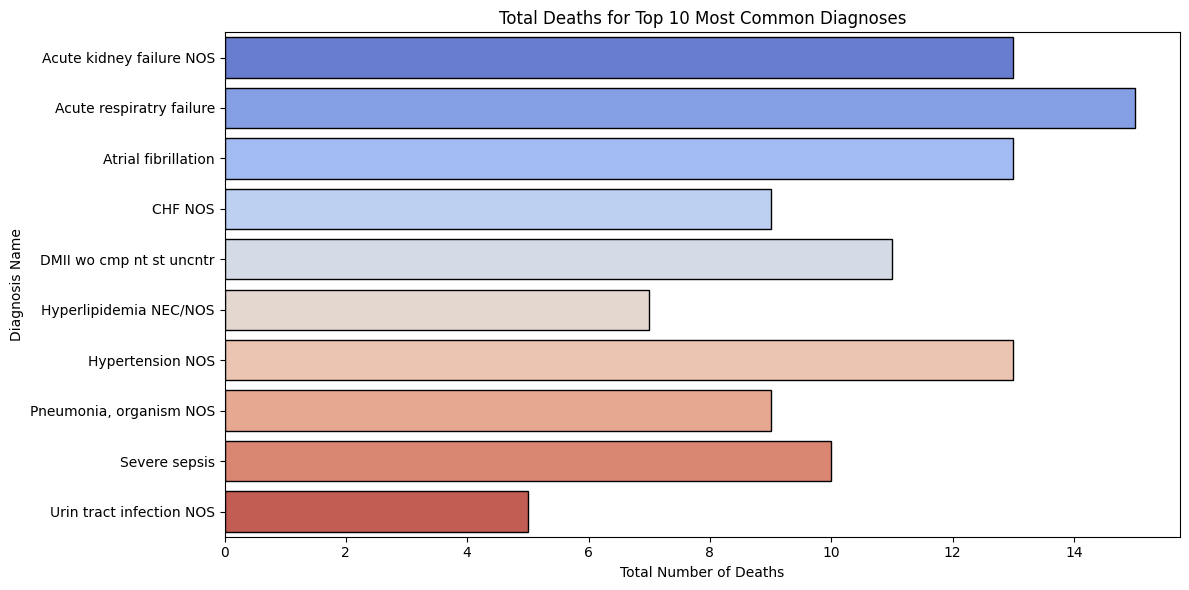

In [50]:
# Calculate total deaths for each of the top 10 most common diagnoses
top_ten_names = most_common_diagnoses_counts.index
total_deaths_top_ten = diagnoses_with_admissions[
    diagnoses_with_admissions['short_title'].isin(top_ten_names)
].groupby('short_title')['hospital_expire_flag'].sum()

# Plot total deaths for the top 10 most common diagnoses
plt.figure(figsize=(12, 6))
sns.barplot(
    x=total_deaths_top_ten.values,
    y=total_deaths_top_ten.index,
    palette="coolwarm",
    edgecolor="black",
    hue=total_deaths_top_ten.index
)
plt.title("Total Deaths for Top 10 Most Common Diagnoses")
plt.xlabel("Total Number of Deaths")
plt.ylabel("Diagnosis Name")
plt.tight_layout()
plt.show()

See which ethnicities have the highest mortality

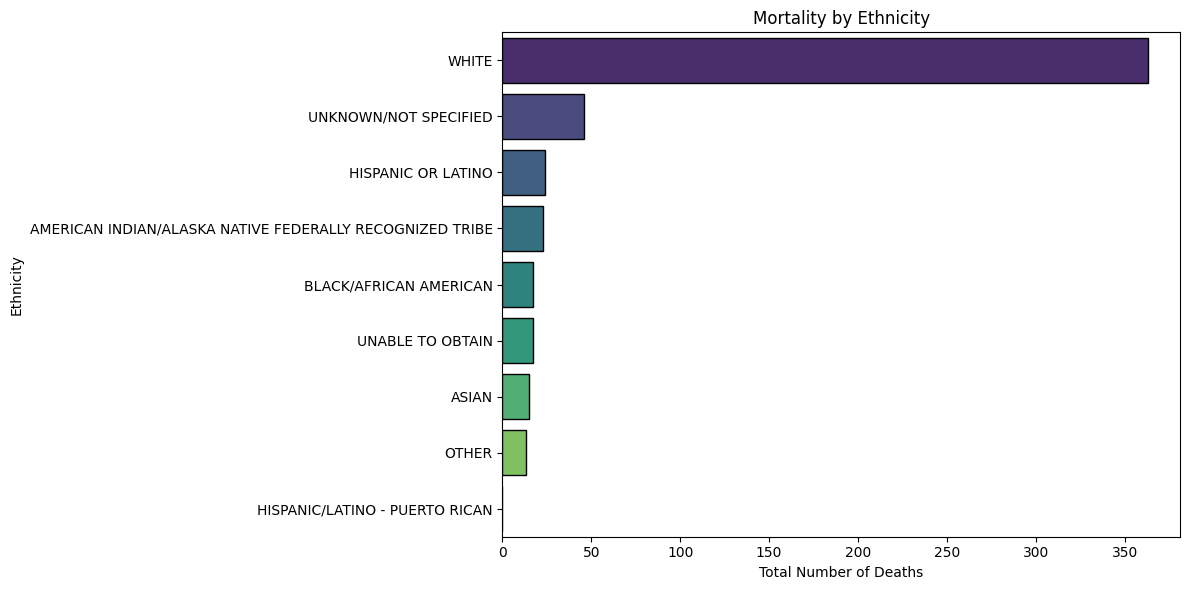

In [51]:
# Group by ethnicity and calculate total mortality
ethnicity_mortality = diagnoses_with_admissions.groupby('ethnicity')['hospital_expire_flag'].sum()

# Sort ethnicities by total mortality in descending order
ethnicity_mortality_sorted = ethnicity_mortality.sort_values(ascending=False)

# Plot the ethnicities with the highest mortality
plt.figure(figsize=(12, 6))
sns.barplot(
    x=ethnicity_mortality_sorted.values,
    y=ethnicity_mortality_sorted.index,
    palette="viridis",
    edgecolor="black",
    hue=ethnicity_mortality_sorted.index
)
plt.title("Mortality by Ethnicity")
plt.xlabel("Total Number of Deaths")
plt.ylabel("Ethnicity")
plt.tight_layout()
plt.show()

Here we can see that White people have the highest mortality. Could this be due to inconsinsites in our data collection?

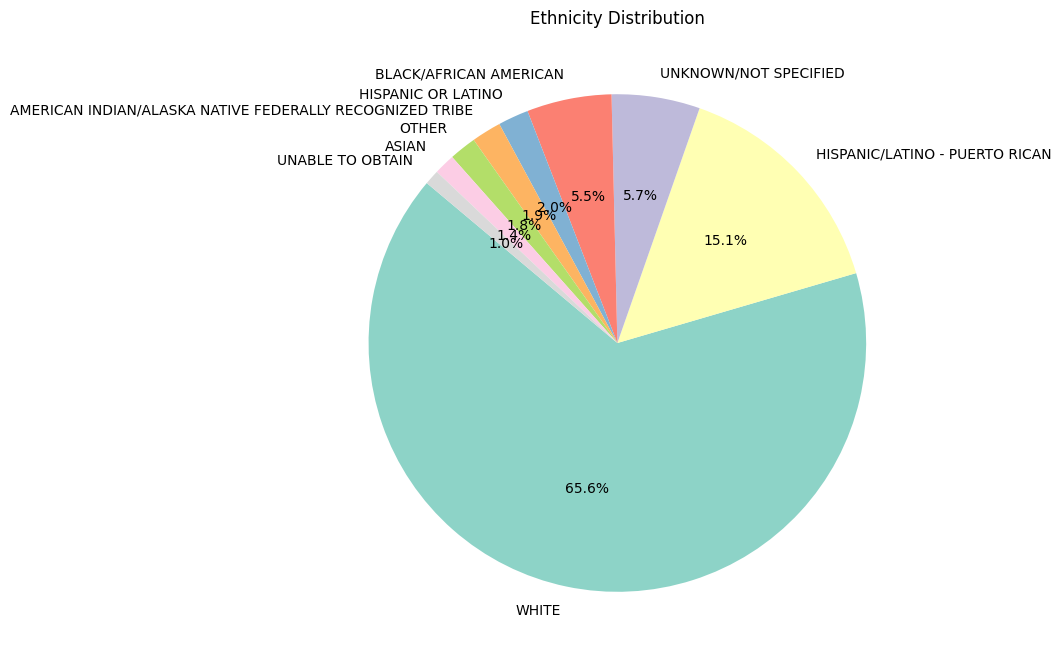

In [52]:
# Count the number of occurrences of each ethnicity
ethnicity_counts = diagnoses_with_admissions['ethnicity'].value_counts()

# Create a pie chart for ethnicity distribution
plt.figure(figsize=(10, 10))
plt.pie(
    ethnicity_counts.values,
    labels=ethnicity_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("Set3", len(ethnicity_counts))
)
plt.title("Ethnicity Distribution")
plt.tight_layout()
plt.show()

Since White accounts for 66% of our data, this is why they have the highest mortality